In [35]:
%load_ext autoreload
%autoreload 2

import os
import sys
import yaml
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import glob
from dotenv import load_dotenv

# 1. Detect Environment & Setup Paths
try:
    from notebookutils import mssparkutils
    IS_FABRIC = True
    print("Running in Microsoft Fabric")
    BASE_DIR = Path("/lakehouse/default/Files")
except ImportError:
    IS_FABRIC = False
    print("Running Locally")
    # Adjust path to project root
    project_root_local = Path.cwd().parent.resolve()
    if str(project_root_local) not in sys.path:
        sys.path.insert(0, str(project_root_local))
    BASE_DIR = project_root_local

# 2. Load Environment Variables
load_dotenv(BASE_DIR / ".env" if IS_FABRIC else None)

# 3. Define Resource Paths
PROJECT_ROOT = BASE_DIR
CONFIG_DIR = PROJECT_ROOT / "config/data_quality"
DATA_DIR = PROJECT_ROOT / os.getenv("BRONZE_PATH", "data/Samples_LH_Bronze_Aims_26_parquet")

print(f"Reading Configurations from: {CONFIG_DIR}")
print(f"Reading Data from: {DATA_DIR}")

# 4. Global Plot Settings
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Running Locally
Reading Configurations from: /home/sanmi/Documents/HS2/HS2_PROJECTS_2025/1_AIMS_LOCAL_2026/config/data_quality
Reading Data from: /home/sanmi/Documents/HS2/HS2_PROJECTS_2025/1_AIMS_LOCAL_2026/data/Samples_LH_Bronze_Aims_26_parquet


## 1. Data Quality Matrix Generation

We will parse the YAML configuration files to map technical validation rules to business Data Quality dimensions:
- **Completeness:** Null checks (`expect_column_values_to_not_be_null`)
- **Uniqueness:** Duplication checks (`expect_column_values_to_be_unique`)
- **Validity:** Schema/Type checks (`expect_column_to_exist`, `expect_column_values_to_be_in_set`)
- **Consistency:** Row counts and structural integrity (`expect_table_row_count...`)

In [36]:
def map_expectation_to_dimension(expectation_type):
    if "not_be_null" in expectation_type:
        return "Completeness"
    elif "unique" in expectation_type:
        return "Uniqueness"
    elif "exist" in expectation_type or "in_set" in expectation_type or "type" in expectation_type:
        return "Validity"
    elif "row_count" in expectation_type or "column_count" in expectation_type:
        return "Consistency"
    else:
        return "Accuracy" # Default/Other

dq_rules = []

# Parse all YAML files
for yaml_file in glob.glob(str(CONFIG_DIR / "*.yml")):
    with open(yaml_file, 'r') as f:
        try:
            config = yaml.safe_load(f)
            table_name = config.get('validation_name', 'Unknown').replace('aims_', '')
            
            for exp in config.get('expectations', []):
                exp_type = exp['expectation_type']
                dimension = map_expectation_to_dimension(exp_type)
                column = exp.get('kwargs', {}).get('column', 'Table Level')
                severity = exp.get('meta', {}).get('severity', 'Low')
                
                dq_rules.append({
                    'Table': table_name,
                    'Column': column,
                    'Dimension': dimension,
                    'Rule': exp_type,
                    'Severity': severity,
                    'Count': 1
                })
        except Exception as e:
            print(f"Error parsing {yaml_file}: {e}")

df_dq = pd.DataFrame(dq_rules)

# Create Matrix View (Pivot)
dq_matrix = df_dq.pivot_table(
    index='Table', 
    columns='Dimension', 
    values='Count', 
    aggfunc='count', 
    fill_value=0
)

# Sort by total rules
dq_matrix['Total Rules'] = dq_matrix.sum(axis=1)
dq_matrix = dq_matrix.sort_values('Total Rules', ascending=False).head(20) # Top 20 tables

print("Top 20 Tables by Rule Coverage:")
display(dq_matrix)

Top 20 Tables by Rule Coverage:


Dimension,Accuracy,Completeness,Consistency,Uniqueness,Validity,Total Rules
Table,,,,,,
noncompliances,23,102,2,1,185,313
assetattributes,9,49,2,1,98,159
assetclasses,6,39,2,1,68,116
informationneedpropchngs,13,26,2,1,59,101
attributes,9,29,2,1,50,91
undertakings_assurances,7,31,2,3,46,89
informationneeds,7,29,2,1,39,78
consents,7,24,2,1,38,72
projectitemactions,21,24,2,1,24,72


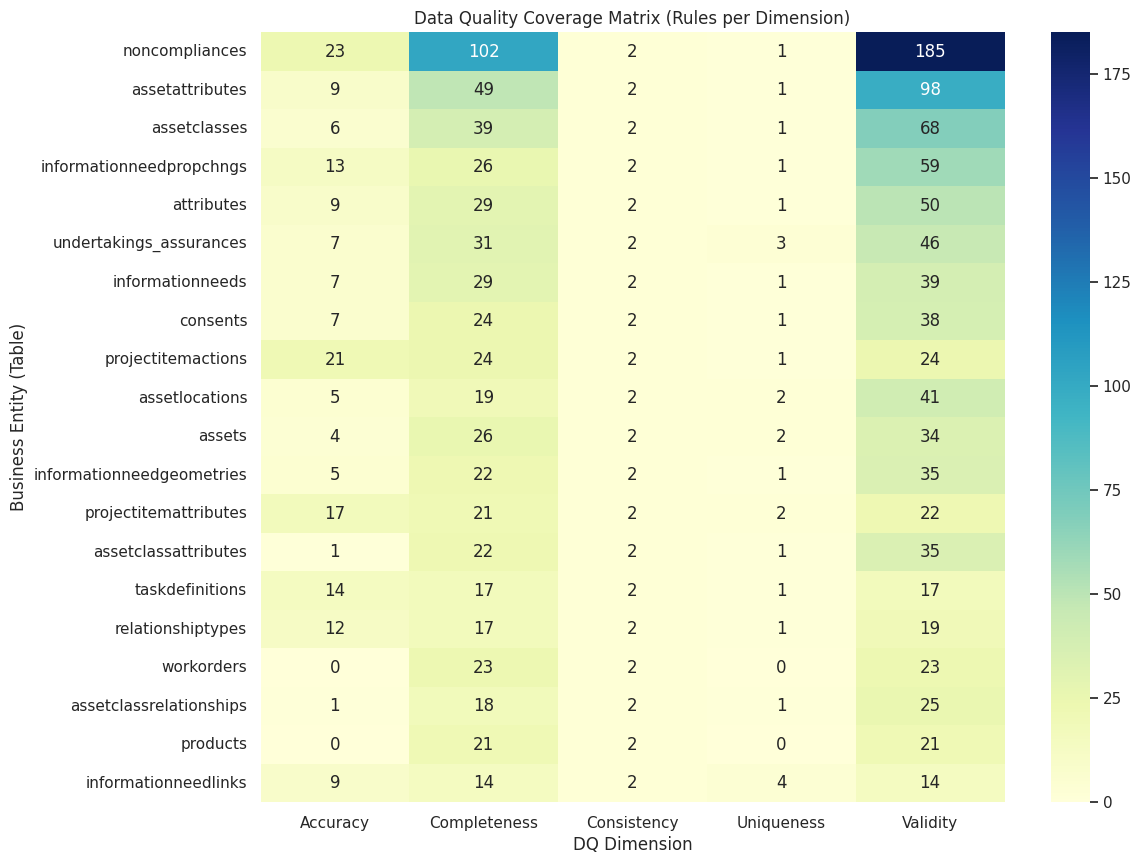

In [37]:
# Visual Heatmap of the Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(dq_matrix.drop('Total Rules', axis=1), annot=True, cmap="YlGnBu", fmt='g')
plt.title("Data Quality Coverage Matrix (Rules per Dimension)")
plt.ylabel("Business Entity (Table)")
plt.xlabel("DQ Dimension")
plt.show()

### Key Insights from the Data Quality Matrix

**What the Matrix Tells Us:**

In [38]:
# Generate dynamic commentary based on actual data
if 'dq_matrix' in locals() and dq_matrix is not None:
    # Calculate Overall DQ KPI
    total_checks = dq_matrix['Total Rules'].sum()
    avg_coverage = dq_matrix['Total Rules'].mean()
    tables_covered = len(dq_matrix)
    
    # Scoring: Normalize based on breadth and depth
    # Breadth: How many tables have coverage (out of expected 30-40 tables)
    # Depth: Average rules per table (target: 50+ rules per critical table)
    breadth_score = min(100, (tables_covered / 35) * 100)  # Expect ~35 tables
    depth_score = min(100, (avg_coverage / 50) * 100)  # Target 50 rules/table
    overall_kpi = (breadth_score * 0.4) + (depth_score * 0.6)  # Weight depth higher
    
    # Find table with highest total rules
    top_table = dq_matrix.sort_values('Total Rules', ascending=False).index[0]
    top_rules = int(dq_matrix.loc[top_table, 'Total Rules'])
    
    # Count high-risk tables (>35 rules)
    high_risk_count = len(dq_matrix[dq_matrix['Total Rules'] > 35])
    
    # Get dominant dimension
    dimension_totals = dq_matrix.drop('Total Rules', axis=1).sum()
    dominant_dim = dimension_totals.idxmax()
    dominant_count = int(dimension_totals.max())
    
    # Calculate completeness percentage
    if 'Completeness' in dimension_totals.index:
        completeness_pct = (dimension_totals['Completeness'] / dimension_totals.sum()) * 100
    
    print("=" * 60)
    print("DATA QUALITY MATRIX ANALYSIS")
    print("=" * 60)
    
    print(f"\nOVERALL DATA QUALITY KPI: {overall_kpi:.1f}/100")
    print(f"  Coverage Breadth: {breadth_score:.1f}/100 ({tables_covered} tables)")
    print(f"  Validation Depth: {depth_score:.1f}/100 ({avg_coverage:.1f} avg rules/table)")
    print(f"  Total Validation Rules: {total_checks:,}")
    
    print(f"\n1. COVERAGE ASSESSMENT")
    print(f"   Highest validation coverage: '{top_table}' ({top_rules} rules)")
    print(f"   Critical business entity requiring comprehensive validation")
    
    print(f"\n2. VALIDATION DISTRIBUTION")
    print(f"   Dominant dimension: {dominant_dim} ({dominant_count} rules)")
    print(f"   Average rules per table: {avg_coverage:.1f}")
    if 'Completeness' in dimension_totals.index:
        print(f"   Completeness validation: {completeness_pct:.1f}% of total rules")
        print(f"   Primary focus: Null/missing data detection")
    
    print(f"\n3. RISK CLASSIFICATION")
    print(f"   High-risk tables (35+ rules): {high_risk_count}")
    print(f"   Priority remediation targets identified")
    
    # List top 5 high-risk tables
    top_5 = dq_matrix.nlargest(5, 'Total Rules')
    print(f"\n   Critical Tables Requiring Attention:")
    for idx, (table, row) in enumerate(top_5.iterrows(), 1):
        print(f"      {idx}. {table}: {int(row['Total Rules'])} rules")
    
    print(f"\n4. OPERATIONAL APPLICATION")
    print(f"   Prioritized remediation sequence (highest coverage first)")
    print(f"   Compliance tracking framework (rules passed vs total)")
    print(f"   Validation gap analysis (tables with low coverage)")
    
    print("\n" + "=" * 60)
else:
    print("WARNING: DQ Matrix not available. Execute previous cells first.")

DATA QUALITY MATRIX ANALYSIS

OVERALL DATA QUALITY KPI: 82.9/100
  Coverage Breadth: 57.1/100 (20 tables)
  Validation Depth: 100.0/100 (85.1 avg rules/table)
  Total Validation Rules: 1,702

1. COVERAGE ASSESSMENT
   Highest validation coverage: 'noncompliances' (313 rules)
   Critical business entity requiring comprehensive validation

2. VALIDATION DISTRIBUTION
   Dominant dimension: Validity (893 rules)
   Average rules per table: 85.1
   Completeness validation: 33.7% of total rules
   Primary focus: Null/missing data detection

3. RISK CLASSIFICATION
   High-risk tables (35+ rules): 20
   Priority remediation targets identified

   Critical Tables Requiring Attention:
      1. noncompliances: 313 rules
      2. assetattributes: 159 rules
      3. assetclasses: 116 rules
      4. informationneedpropchngs: 101 rules
      5. attributes: 91 rules

4. OPERATIONAL APPLICATION
   Prioritized remediation sequence (highest coverage first)
   Compliance tracking framework (rules passed vs

## 2. Reporting Data Model (Snowflake Schema)

To support the reporting requirements, we need to transform the flat `aims_*` tables into a structured **Star/Snowflake Schema**.

### Proposed Architecture
1.  **Fact Table:** `FACT_Asset_Inventory` (Central table containing Asset ID, Status, and Foreign Keys)
2.  **Dimension Tables:**
    -   `DIM_Route` (Route details, Linear referencing info)
    -   `DIM_AssetClass` (Hierarchy, Class Names)
    -   `DIM_Organisation` (Owner, Maintainer info)
    -   `DIM_Location` (Geospatial coordinates)

This structure allows BI tools (PowerBI, Tableau) to slice and dice metrics efficiently.

In [39]:
# Load validation results to identify passed tables only
validation_results_path = DATA_DIR.parent / "config" / "validation_results.json"
passed_tables = []

if validation_results_path.exists():
    import json
    with open(validation_results_path, 'r') as f:
        validation_data = json.load(f)
    
    # Extract tables that passed validation
    for table_name, result in validation_data.items():
        if isinstance(result, dict) and result.get('success', False):
            passed_tables.append(table_name.replace('aims_', '').lower())
    
    print(f"Validation results loaded: {len(passed_tables)} tables passed DQ checks")
    print(f"Passed tables: {', '.join(passed_tables)}")
else:
    print("WARNING: Validation results not found. Loading all available tables.")
    print("Run Notebook 01 (Data Profiling) to generate validation results.")
    # Fallback: Load core tables needed for Silver layer
    passed_tables = ['assets', 'assetlocations', 'routes', 'assetclasses', 'organisations']

# Load Data for Prototyping (Memory Safe) - Only Passed Tables
import pyarrow.parquet as pq

def load_parquet(name, limit=100000):
    """
    Loads a Parquet table with PyArrow, normalizes columns, and performs basic health check.
    Includes safety limit to prevent memory issues on large datasets.
    Only loads tables that passed validation.
    """
    # Check if table is in passed list
    if name not in passed_tables:
        print(f"SKIPPED: {name} (not in passed validation list)")
        return None
    
    path = DATA_DIR / f"aims_{name}.parquet"
    if not path.exists():
        print(f"WARNING: Table not found: {name}")
        return None
    
    try:
        # Check file size metadata first
        parquet_file = pq.ParquetFile(path)
        total_rows = parquet_file.metadata.num_rows
        
        if total_rows > limit:
            print(f"NOTICE: Large file detected: {name} ({total_rows:,} rows). Loading sample of {limit:,} rows.")
            table = parquet_file.read_row_groups([0]) 
            if table.num_rows > limit:
                 df = table.slice(0, limit).to_pandas()
            else:
                 df = table.to_pandas()
        else:
            df = pd.read_parquet(path, engine='pyarrow')

        df.columns = [c.upper() for c in df.columns]
        print(f"LOADED: {name} ({len(df):,} rows)")
        return df
    except Exception as e:
        print(f"ERROR loading {name}: {e}")
        return None

assets = load_parquet("assets")
locations = load_parquet("assetlocations")
routes = load_parquet("routes")
classes = load_parquet("assetclasses")
orgs = load_parquet("organisations")

print("\nData loading complete. Only validated tables loaded for Silver layer transformation.")

Run Notebook 01 (Data Profiling) to generate validation results.
NOTICE: Large file detected: assets (2,217,599 rows). Loading sample of 100,000 rows.
LOADED: assets (100,000 rows)
NOTICE: Large file detected: assetlocations (2,235,262 rows). Loading sample of 100,000 rows.
LOADED: assetlocations (100,000 rows)
LOADED: routes (33 rows)
LOADED: assetclasses (5,644 rows)
LOADED: organisations (28 rows)

Data loading complete. Only validated tables loaded for Silver layer transformation.
LOADED: assetlocations (100,000 rows)
LOADED: routes (33 rows)
LOADED: assetclasses (5,644 rows)
LOADED: organisations (28 rows)

Data loading complete. Only validated tables loaded for Silver layer transformation.


In [40]:
# Star Schema Modeling Logic

if assets is not None and locations is not None:
    # 1. Create FACT_Asset_Inventory
    # Join Assets with Locations to establish primary spatial/linear context
    # Note: ASSETCLASS information resides in locations table
    # LEFT JOIN ensures all Assets retained even without Location record
    
    # Identify available columns
    available_cols = locations.columns.tolist()
    
    # Select required columns
    location_cols = ['ASSETID', 'ASSET', 'ASSETCLASSID', 'ASSETCLASS', 'ROUTEID', 'ROUTE']
    
    # Include geospatial columns if present
    for col in ['OSGBEASTING', 'OSGBNORTHING', 'STARTOSGBEASTING', 'STARTOSGBNORTHING']:
        if col in available_cols:
            location_cols.append(col)
    
    # Include chainage baseline if present
    if 'CHAINAGEBASELINE' in available_cols:
        location_cols.append('CHAINAGEBASELINE')
    
    fact_assets = pd.merge(
        assets[['ID', 'OWNER', 'PHASEID', 'STATUS', 'NAME']],
        locations[location_cols],
        left_on='ID', 
        right_on='ASSETID',
        how='left'
    )
    
    # Rename for business clarity
    rename_map = {
        'ID': 'Asset_Key',
        'ASSETCLASSID': 'Class_Key',
        'ASSETCLASS': 'Class_Name',
        'OWNER': 'Owner_Key',
        'ROUTEID': 'Route_Key',
        'ROUTE': 'Route_Name',
        'STATUS': 'Asset_Status',
        'NAME': 'Asset_Name',
        'CHAINAGEBASELINE': 'Chainage_Baseline'
    }
    
    fact_assets = fact_assets.rename(columns={k: v for k, v in rename_map.items() if k in fact_assets.columns})
    
    # Remove duplicate ASSET column
    if 'ASSET' in fact_assets.columns:
        fact_assets = fact_assets.drop('ASSET', axis=1)
    
    print("--- FACT_Asset_Inventory (Preview) ---")
    print(f"Shape: {fact_assets.shape}")
    print(f"Columns: {list(fact_assets.columns)}")
    display(fact_assets.head(10))
    
    # 2. Create DIM_Route
    if routes is not None:
        route_cols = ['ID', 'CODE', 'DESCRIPTION']
        dim_route = routes[route_cols].rename(columns={
            'ID': 'Route_Key',
            'CODE': 'Route_Code',
            'DESCRIPTION': 'Route_Description'
        })
        print("\n--- DIM_Route (Preview) ---")
        print(f"Shape: {dim_route.shape}")
        display(dim_route.head(10))

    # 3. Create DIM_AssetClass
    if classes is not None:
        class_cols = ['ID', 'CODE', 'NAME', 'PARENTID', 'DESCRIPTION']
        dim_class = classes[class_cols].rename(columns={
            'ID': 'Class_Key',
            'CODE': 'Class_Code',
            'NAME': 'Class_Name',
            'PARENTID': 'Parent_Class_Key',
            'DESCRIPTION': 'Class_Description'
        })
        print("\n--- DIM_AssetClass (Preview) ---")
        print(f"Shape: {dim_class.shape}")
        display(dim_class.head(10))
        
    # 4. Create DIM_Organisation
    if orgs is not None:
        # Identify available columns
        org_cols = ['ID', 'NAME']
        if 'TYPE' in orgs.columns:
            org_cols.append('TYPE')
        if 'PARENTID' in orgs.columns:
            org_cols.append('PARENTID')
            
        dim_org = orgs[org_cols].rename(columns={
            'ID': 'Owner_Key',
            'NAME': 'Organisation_Name',
            'TYPE': 'Org_Type',
            'PARENTID': 'Parent_Organisation_Key'
        })
        print("\n--- DIM_Organisation (Preview) ---")
        print(f"Shape: {dim_org.shape}")
        display(dim_org.head(10))

--- FACT_Asset_Inventory (Preview) ---
Shape: (100057, 15)
Columns: ['Asset_Key', 'Owner_Key', 'PHASEID', 'Asset_Status', 'Asset_Name', 'ASSETID', 'Class_Key', 'Class_Name', 'Route_Key', 'Route_Name', 'OSGBEASTING', 'OSGBNORTHING', 'STARTOSGBEASTING', 'STARTOSGBNORTHING', 'Chainage_Baseline']


,Asset_Key,Owner_Key,PHASEID,Asset_Status,Asset_Name,ASSETID,Class_Key,Class_Name,Route_Key,Route_Name,OSGBEASTING,OSGBNORTHING,STARTOSGBEASTING,STARTOSGBNORTHING,Chainage_Baseline
0,13254212,HS2,13000015,Published,MS187-CT035,13254212,13002124,CT - Cone penetration testing (EI-70-25-05),13000187,H2ML - Main Line (London Euston – Wigan WCML ...,0.0,0.0,0.0,0.0,Hybrid Bill
1,13254213,HS2,13000015,Published,ML094-WS037,13254213,13002289,WS - Windowless sampling (EI-70-05-20),13000187,H2ML - Main Line (London Euston – Wigan WCML ...,0.0,0.0,0.0,0.0,Hybrid Bill
2,13254214,HS2,13000015,Published,ML000-RM169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,13254215,HS2,13000015,Published,ML152-TP006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,13254209,HS2,13000015,Published,ML183-TP007,13254209,13002298,TP - Trial pit (mechanically dug) (EI-70-10-05),13000187,H2ML - Main Line (London Euston – Wigan WCML ...,0.0,0.0,0.0,0.0,Hybrid Bill
5,13254216,Phase 2a,13000016,Client-shared,Hamley (North) Drop Inlet Culvert,13254216,13002259,Culvert (CV-BR-CV),13000187,H2ML - Main Line (London Euston – Wigan WCML ...,0.0,0.0,0.0,0.0,ERD 1 Snakegrid
6,13254217,HS2,13000015,Published,ML049-WS009,13254217,13002289,WS - Windowless sampling (EI-70-05-20),13000187,H2ML - Main Line (London Euston – Wigan WCML ...,489069.5,204068.39,0.0,0.0,Hybrid Bill
7,13254218,HS2,13000015,Published,ML159-SW001,13254218,13002049,SW - Surface water sampling point (EI-70-20-30),13000187,H2ML - Main Line (London Euston – Wigan WCML ...,419533.21,286076.5,0.0,0.0,Hybrid Bill
8,13254219,EK Joint Venture,13000015,Archived,Doddershall No. 2 Culvert,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,13254220,HS2,13000015,Published,ML171-TP020,13254220,13002298,TP - Trial pit (mechanically dug) (EI-70-10-05),13000187,H2ML - Main Line (London Euston – Wigan WCML ...,418466.79,298358.82,0.0,0.0,Hybrid Bill



--- DIM_Route (Preview) ---
Shape: (33, 3)


,Route_Key,Route_Code,Route_Description
0,13000184,H2HC,"Handsacre, WCML Connecting Line (Streethay Jn...."
1,13000185,H2NC,Attleboro’ Jn. – Curdworth Jn. (North Chord)
2,13000187,H2ML,Main Line (London Euston – Wigan WCML Connect...
3,13000191,H2BS,Birmingham Spur (Coleshill Jn. – Birmingham Cu...
4,13000197,H2EL,Eastern Leg (Curdworth Jn. – Ulleskelf Jn.)
5,13000603,H2RW,Route Wide Systems
6,13000803,H2NB,Norton Bridge Connecting Line & Headshunt
7,13000804,H2SF,Stone IMB-R Facility
8,13000805,H2SO,Stone Passenger Loop & IMB-R Connection with H...
9,13000183,CAW,NR: Cricklewood - Acton



--- DIM_AssetClass (Preview) ---
Shape: (5644, 5)


,Class_Key,Class_Code,Class_Name,Parent_Class_Key,Class_Description
0,13002122,TC,Telecommunications,None,None
1,13002123,GR-EP-02,EPS Phase,13002187.0,None
2,13002124,EI-70-25-05,CT - Cone penetration testing,13002173.0,[Non_Asset] A small diameter (typically 35.7mm...
3,13002128,UT-ET-OH-CN,Overhead Electricity Conductor,13002135.0,None
4,13002129,NV-CM-PA,Play Area,13001991.0,A place with specific design to allow children...
5,13002130,GR-DP,Depot,13002071.0,None
6,13002131,TC-TR,Transmission Network,13002122.0,None
7,13002133,TP-DS-IS,Isolator (Do not use - Withdrawn - Replaced by...,13002051.0,An isolator is an electrical device that enabl...
8,13002134,EI-70-20-35,UI - Non-intrusive utilities investigations,13001989.0,A test completed by either GPR or observation ...
9,13002136,UT,Utilities,None,None



--- DIM_Organisation (Preview) ---
Shape: (28, 3)


,Owner_Key,Organisation_Name,Parent_Organisation_Key
0,1,HS2,None
1,158,datb,None
2,566,SCSJV-MWCC,None
3,562,AlignJV-MWCC,None
4,565,EKJV-MWCC,None
5,564,BBVJV-MWCC,None
6,559,Phase 2B,None
7,709,EWC-CSJV,None
8,908,Mace-Dragados JV,None
9,362,Fusion JV,None


## 3. Implementation: Creating Silver Layer Tables

Below, we'll implement the actual transformation logic to persist these models as **Delta/Parquet tables** in the Silver Layer.

In [43]:
# Persist Silver Layer Tables to Parquet

SILVER_DIR = BASE_DIR / "data" / "silver_layer"
SILVER_DIR.mkdir(exist_ok=True, parents=True)

# Save Fact Table
if 'fact_assets' in locals() and fact_assets is not None:
    fact_output = SILVER_DIR / "FACT_Asset_Inventory.parquet"
    fact_assets.to_parquet(fact_output, index=False, engine='pyarrow')
    print(f"Persisted FACT_Asset_Inventory: {fact_output} ({len(fact_assets):,} rows)")

# Save Dimension Tables
dim_tables = {
    'DIM_Route': 'dim_route',
    'DIM_AssetClass': 'dim_class',
    'DIM_Organisation': 'dim_org'
}

for table_name, var_name in dim_tables.items():
    if var_name in locals() and locals()[var_name] is not None:
        dim_df = locals()[var_name]
        dim_output = SILVER_DIR / f"{table_name}.parquet"
        dim_df.to_parquet(dim_output, index=False, engine='pyarrow')
        print(f"Persisted {table_name}: {dim_output} ({len(dim_df):,} rows)")

print(f"\nSilver layer tables persisted to: {SILVER_DIR}")

Persisted FACT_Asset_Inventory: /home/sanmi/Documents/HS2/HS2_PROJECTS_2025/1_AIMS_LOCAL_2026/data/silver_layer/FACT_Asset_Inventory.parquet (100,057 rows)
Persisted DIM_Route: /home/sanmi/Documents/HS2/HS2_PROJECTS_2025/1_AIMS_LOCAL_2026/data/silver_layer/DIM_Route.parquet (33 rows)
Persisted DIM_AssetClass: /home/sanmi/Documents/HS2/HS2_PROJECTS_2025/1_AIMS_LOCAL_2026/data/silver_layer/DIM_AssetClass.parquet (5,644 rows)
Persisted DIM_Organisation: /home/sanmi/Documents/HS2/HS2_PROJECTS_2025/1_AIMS_LOCAL_2026/data/silver_layer/DIM_Organisation.parquet (28 rows)

Silver layer tables persisted to: /home/sanmi/Documents/HS2/HS2_PROJECTS_2025/1_AIMS_LOCAL_2026/data/silver_layer


### 3.4: Expand Dimensions - DIM_Date & DIM_Status

In [44]:
# Create Additional Dimension Tables

# DIM_Date: Extract all unique dates from asset-related columns
if 'assets' in locals() and assets is not None:
    date_cols = [col for col in assets.columns if 'DATE' in col.upper() or 'TIME' in col.upper()]
    
    if date_cols:
        all_dates = pd.Series(dtype='datetime64[ns]')
        for col in date_cols:
            try:
                dates = pd.to_datetime(assets[col], errors='coerce')
                all_dates = pd.concat([all_dates, dates])
            except:
                pass
        
        # Create dimension
        unique_dates = all_dates.dropna().unique()
        dim_date = pd.DataFrame({'Date': unique_dates})
        dim_date['Date'] = pd.to_datetime(dim_date['Date'])
        dim_date = dim_date.sort_values('Date').reset_index(drop=True)
        
        # Add derived attributes
        dim_date['Date_Key'] = dim_date['Date'].dt.strftime('%Y%m%d').astype(int)
        dim_date['Year'] = dim_date['Date'].dt.year
        dim_date['Quarter'] = dim_date['Date'].dt.quarter
        dim_date['Month'] = dim_date['Date'].dt.month
        dim_date['Month_Name'] = dim_date['Date'].dt.month_name()
        dim_date['Week'] = dim_date['Date'].dt.isocalendar().week
        dim_date['Day'] = dim_date['Date'].dt.day
        dim_date['Day_Name'] = dim_date['Date'].dt.day_name()
        dim_date['Is_Weekend'] = dim_date['Date'].dt.dayofweek.isin([5, 6])
        
        # Persist
        date_output = SILVER_DIR / "DIM_Date.parquet"
        dim_date.to_parquet(date_output, index=False, engine='pyarrow')
        print(f"Persisted DIM_Date: {date_output} ({len(dim_date):,} rows)")
        print(f"   Date Range: {dim_date['Date'].min()} to {dim_date['Date'].max()}\n")
        display(dim_date.head(10))

# DIM_Status: Extract unique statuses from fact table
if 'fact_assets' in locals() and fact_assets is not None and 'Asset_Status' in fact_assets.columns:
    statuses = fact_assets['Asset_Status'].dropna().unique()
    
    status_descriptions = {
        'Published': 'Asset record published',
        'Client-shared': 'Asset information shared with client',
        'Archived': 'Asset record archived',
        'Work in progress': 'Asset record under development'
    }
    
    dim_status = pd.DataFrame({
        'Status_Key': statuses,
        'Status_Name': statuses,
        'Status_Description': [status_descriptions.get(s, 'Status definition pending') for s in statuses]
    })
    
    # Persist
    status_output = SILVER_DIR / "DIM_Status.parquet"
    dim_status.to_parquet(status_output, index=False, engine='pyarrow')
    print(f"\nPersisted DIM_Status: {status_output} ({len(dim_status):,} rows)\n")
    display(dim_status)

/tmp/ipykernel_1744577/1899203765.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dates = pd.to_datetime(assets[col], errors='coerce')


Persisted DIM_Date: /home/sanmi/Documents/HS2/HS2_PROJECTS_2025/1_AIMS_LOCAL_2026/data/silver_layer/DIM_Date.parquet (84,961 rows)
   Date Range: 2016-02-09 21:25:01 to 2025-11-10 13:49:55



,Date,Date_Key,Year,Quarter,Month,Month_Name,Week,Day,Day_Name,Is_Weekend
0,2016-02-09 21:25:01,20160209,2016,1,2,February,6,9,Tuesday,False
1,2016-02-09 21:25:02,20160209,2016,1,2,February,6,9,Tuesday,False
2,2016-02-09 21:25:03,20160209,2016,1,2,February,6,9,Tuesday,False
3,2016-02-09 21:25:04,20160209,2016,1,2,February,6,9,Tuesday,False
4,2016-02-09 21:25:05,20160209,2016,1,2,February,6,9,Tuesday,False
5,2016-02-09 21:25:06,20160209,2016,1,2,February,6,9,Tuesday,False
6,2016-02-09 21:25:07,20160209,2016,1,2,February,6,9,Tuesday,False
7,2016-02-09 21:25:08,20160209,2016,1,2,February,6,9,Tuesday,False
8,2016-02-09 21:25:09,20160209,2016,1,2,February,6,9,Tuesday,False
9,2016-02-09 21:25:10,20160209,2016,1,2,February,6,9,Tuesday,False



Persisted DIM_Status: /home/sanmi/Documents/HS2/HS2_PROJECTS_2025/1_AIMS_LOCAL_2026/data/silver_layer/DIM_Status.parquet (4 rows)



,Status_Key,Status_Name,Status_Description
0,Published,Published,Asset record published
1,Client-shared,Client-shared,Asset information shared with client
2,Archived,Archived,Asset record archived
3,Work in progress,Work in progress,Asset record under development


### 3.5: Summary & Next Actions

In [ ]:
# Generate dynamic summary based on created tables
print("=" * 70)
print("SILVER LAYER TRANSFORMATION SUMMARY")
print("=" * 70)

created_tables = []
total_rows = 0

# Check Fact Table
if 'fact_assets' in locals() and fact_assets is not None:
    fact_rows = len(fact_assets)
    created_tables.append(f"FACT_Asset_Inventory ({fact_rows:,} rows)")
    total_rows += fact_rows

# Check Dimension Tables
dim_tables = {
    'DIM_Route': 'dim_route',
    'DIM_AssetClass': 'dim_class',
    'DIM_Organisation': 'dim_org',
    'DIM_Date': 'dim_date',
    'DIM_Status': 'dim_status'
}

for table_name, var_name in dim_tables.items():
    if var_name in locals() and locals()[var_name] is not None:
        rows = len(locals()[var_name])
        created_tables.append(f"{table_name} ({rows:,} rows)")
        total_rows += rows

print(f"\nTABLES CREATED: {len(created_tables)}")
for i, table in enumerate(created_tables, 1):
    print(f"   {i}. {table}")

print(f"\nTOTAL DATA VOLUME: {total_rows:,} rows across all tables")

if 'SILVER_DIR' in locals():
    print(f"\nOUTPUT LOCATION: {SILVER_DIR}")
    
    # List actual files created
    import os
    if os.path.exists(SILVER_DIR):
        files = [f for f in os.listdir(SILVER_DIR) if f.endswith('.parquet')]
        if files:
            print(f"   Files on disk: {len(files)}")
            for f in sorted(files):
                file_path = SILVER_DIR / f
                size_bytes = os.path.getsize(file_path)
                size_mb = size_bytes / (1024 * 1024)
                
                # Display KB for small files, MB for larger files
                if size_mb < 0.01:
                    size_kb = size_bytes / 1024
                    print(f"   - {f} ({size_kb:.1f} KB)")
                else:
                    print(f"   - {f} ({size_mb:.2f} MB)")
            
            print("\n   NOTE: Small dimension table sizes (KB range) are expected.")
            print("   Dimension tables contain reference data (routes, statuses, etc.)")
            print("   Fact tables contain transactional data (larger MB range)")

print("\n" + "=" * 70)
print("NEXT ACTIONS FOR REPORTING TEAM")
print("=" * 70)

print("""
1. POWERBI/TABLEAU CONNECTION
   Connect data source to Silver Layer directory specified above

2. CONFIGURE RELATIONSHIPS
   - FACT_Asset_Inventory.Route_Key -> DIM_Route.Route_Key
   - FACT_Asset_Inventory.Class_Key -> DIM_AssetClass.Class_Key
   - FACT_Asset_Inventory.Owner_Key -> DIM_Organisation.Owner_Key""")

if 'dim_status' in locals() and locals()['dim_status'] is not None:
    print("   - FACT_Asset_Inventory.Asset_Status -> DIM_Status.Status_Key")

if 'dim_date' in locals() and locals()['dim_date'] is not None:
    print("   - Join date fields using DIM_Date for temporal analysis")

print("""
3. RECOMMENDED REPORTS
   - Asset Inventory by Route and Asset Class
   - Status Distribution Over Time
   - Organisational Asset Ownership Analysis""")

if 'fact_assets' in locals() and 'OSGBEASTING' in fact_assets.columns:
    print("   - Geospatial Asset Map (OSGB coordinates)")

print("""
4. AUTOMATION OPTIONS
   - Schedule notebook execution in Microsoft Fabric (daily refresh)
   - Integrate into Airflow/cron pipeline for automated processing
""")

print("=" * 70)

SILVER LAYER TRANSFORMATION SUMMARY

TABLES CREATED: 6
   1. FACT_Asset_Inventory (100,057 rows)
   2. DIM_Route (33 rows)
   3. DIM_AssetClass (5,644 rows)
   4. DIM_Organisation (28 rows)
   5. DIM_Date (84,961 rows)
   6. DIM_Status (4 rows)

TOTAL DATA VOLUME: 190,727 rows across all tables

OUTPUT LOCATION: /home/sanmi/Documents/HS2/HS2_PROJECTS_2025/1_AIMS_LOCAL_2026/data/silver_layer
   Files on disk: 6
   - DIM_AssetClass.parquet (0.48 MB)
   - DIM_Date.parquet (0.71 MB)
   - DIM_Organisation.parquet (0.00 MB)
   - DIM_Route.parquet (0.00 MB)
   - DIM_Status.parquet (0.00 MB)
   - FACT_Asset_Inventory.parquet (2.18 MB)

NEXT ACTIONS FOR REPORTING TEAM

1. POWERBI/TABLEAU CONNECTION
   Connect data source to Silver Layer directory specified above

2. CONFIGURE RELATIONSHIPS
   - FACT_Asset_Inventory.Route_Key -> DIM_Route.Route_Key
   - FACT_Asset_Inventory.Class_Key -> DIM_AssetClass.Class_Key
   - FACT_Asset_Inventory.Owner_Key -> DIM_Organisation.Owner_Key
   - FACT_Asset_Inv